sudo apt-get install portaudio19-dev

In [1]:
!pip install pyaudio

In [45]:
import pyaudio
import wave
import numpy as np
import time
from IPython.display import Audio
import librosa

In [3]:
RATE = 22050

In [4]:
CHUNK = librosa.time_to_samples(0.3)[0]

In [5]:
FORMAT = pyaudio.paInt16
CHANNELS = 1
RECORD_SECONDS = 5
WAVE_OUTPUT_FILENAME = "output.wav"

p = pyaudio.PyAudio()

In [6]:
stream = p.open(format=FORMAT,
                channels=CHANNELS,
                rate=RATE,
                input=True,
                frames_per_buffer=CHUNK)

buf = stream.read(CHUNK)
signal = np.fromstring(buf, dtype=np.int16)

In [7]:
Audio(signal, rate=RATE)

https://stackoverflow.com/questions/28417733/pyaudio-responsive-recording

In [8]:
res = []

i = 0
def callback(in_data, frame_count, time_info, status):
    global res, i
    
    signal = np.fromstring(in_data, dtype=np.int16)
    time.sleep(0.5) # nn
    res.extend(signal)
    print(i)
    i += 1
    if i == 5:
        return (in_data, pyaudio.paComplete)
    else:
        return(in_data, pyaudio.paContinue)

stream = p.open(format=FORMAT,
                channels=CHANNELS,
                rate=RATE,
                input=True,
                frames_per_buffer=CHUNK,
                stream_callback=callback)

0
1
2
3
4


In [9]:
len(res)

33075

In [10]:
CHUNK * 5

33075

In [11]:
Audio(res, rate=RATE)

# Loading model

In [14]:
from keras.models import load_model, model_from_json

In [16]:
# model = model_from_json('../cache/model2.json')

In [17]:
# model = load_model('../cache/model2.h5')

In [18]:
import keras
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, AveragePooling2D
from keras.layers import GRU, BatchNormalization
from keras.utils import to_categorical
from keras.layers import Input, Conv1D, Activation, MaxPool1D
from keras.models import Model

In [19]:
def create_model(input_shape):
    x_input = Input(input_shape)
#     x = Conv1D(64, 1)(x_input)
#     x = Activation('relu')(x)
    x = Conv1D(128, 3)(x_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)
    
    x = GRU(128, return_sequences=True)(x)
    x = Dropout(0.5)(x)
    x = BatchNormalization()(x)
    
    x = GRU(192, return_sequences=False)(x)
    x = Dropout(0.5)(x)
    x = BatchNormalization()(x)
    
    x = Dense(3, activation='softmax')(x)
    model = Model(inputs=x_input, outputs=x)
    return model

In [20]:
inp_shape =(28, 100)

In [21]:
model = create_model(inp_shape)

In [22]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 100)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 26, 128)           38528     
_________________________________________________________________
batch_normalization_1 (Batch (None, 26, 128)           512       
_________________________________________________________________
activation_1 (Activation)    (None, 26, 128)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 26, 128)           0         
_________________________________________________________________
gru_1 (GRU)                  (None, 26, 128)           98688     
_________________________________________________________________
dropout_2 (Dropout)          (None, 26, 128)           0         
__________

In [23]:
model.load_weights('../cache/model2_weights.h5')

In [37]:
model.predict(np.random.rand(1, 28, 100))

array([[  9.47452383e-04,   1.42122110e-04,   9.98910427e-01]], dtype=float32)

In [38]:
mean, std = (-20.350365, 2.89434)

# Preprocess

In [39]:
from scipy.fftpack import fft
from scipy import signal

In [40]:
sample_rate = 22050

In [41]:
def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

In [42]:
# X = [x if type(x) == type(np.array([])) else np.array(x) for x in X]

In [125]:
def extract_features(x, lim=100):
    _, _, spec = log_specgram(x, sample_rate)
#     return np.expand_dims(spec[:, :100], -1)
    spec -= m
    spec /= s
    return spec[:, :100]

# Realtime prediction

In [126]:
import pyaudio
from queue import Queue
from threading import Thread
import sys
import time

In [127]:
# Queue to communiate between the audio callback and main thread
q = Queue()

run = True

# silence_threshold = 100

# Run the demo for a timeout seconds
timeout = time.time() + 0.2*60  # 0.5 minutes from now

# Data buffer for the input wavform
# data = np.zeros(feed_samples, dtype='int16')

# def callback(in_data, frame_count, time_info, status):
#     global res, i
    
#     signal = np.fromstring(in_data, dtype=np.int16)
#     time.sleep(0.5) # nn
#     res.extend(signal)
#     print(i)
#     i += 1
#     if i == 5:
#         return (in_data, pyaudio.paComplete)
#     else:
#         return(in_data, pyaudio.paContinue)

res = []

def callback(in_data, frame_count, time_info, status):
    global run, timeout, res#, silence_threshold    
    if time.time() > timeout:
        run = False        
    data = np.frombuffer(in_data, dtype='int16')
    res.extend(data)
#     if np.abs(data0).mean() < silence_threshold:
#         sys.stdout.write('-')
#         return (in_data, pyaudio.paContinue)
#     else:
#         sys.stdout.write('.')
#     data = np.append(data,data0)    
#     if len(data) > feed_samples:
#         data = data[-feed_samples:]
        # Process data async by sending a queue.
    q.put(data)
    return (in_data, pyaudio.paContinue)

# stream = get_audio_input_stream(callback)
# stream.start_stream()

stream = p.open(format=FORMAT,
                channels=CHANNELS,
                rate=RATE,
                input=True,
                frames_per_buffer=CHUNK,
                stream_callback=callback)

specs_all = []
preds_all = []

try:
    while run:
        data = q.get()
        spectrum = extract_features(data)
        specs_all.append(spectrum)
        preds = model.predict(np.expand_dims(spectrum, 0))
        preds_all.append(preds)
        preds = preds.argmax(1)[0]
#         new_trigger = has_new_triggerword(preds, chunk_duration, feed_duration)
#         if new_trigger:
        sys.stdout.write(str(preds))
except (KeyboardInterrupt, SystemExit):
    stream.stop_stream()
    stream.close()
    timeout = time.time()
    run = False
        
stream.stop_stream()
stream.close()

2222222222222222222222222222212222222222222222212222221112221122222222222222222222222222222222222222222222220222222222

In [128]:
len(res)

264600

In [129]:
Audio(res, rate=sample_rate)

## Result

In [130]:
import matplotlib.pyplot as plt
%matplotlib inline

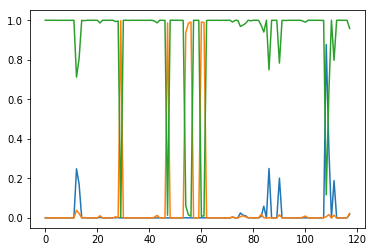

In [131]:
plt.plot(np.vstack(preds_all))

In [123]:
# m = specs_all[0].mean()
# m

-5.3016729

In [124]:
# s = specs_all[0].std()
# s

1.8701094

In [101]:
np.stack(specs_all).mean()

-4.1887031

In [102]:
np.stack(specs_all).std()

2.6035542

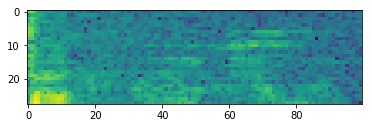

In [104]:
plt.imshow(specs_all[23])